In [1]:
 !python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


#Configuración del ambiente

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from urllib.request import urlopen, urlretrieve
from bs4 import BeautifulSoup
import requests

global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

#2. Obtención de datos

In [3]:
def importar_base_datos_bitcoin():
  global df_bitcoin
  df_bitcoin = yf.download('BTC-USD', period='7d', interval='5m')
  
importar_base_datos_bitcoin()
df_bitcoin.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-05-12 00:00:00+00:00,26987.662109,27006.585938,26987.662109,26990.148438,26990.148438,0
2023-05-12 00:05:00+00:00,26993.667969,26993.667969,26977.453125,26977.453125,26977.453125,0
2023-05-12 00:10:00+00:00,26974.347656,26974.347656,26965.638672,26965.835938,26965.835938,0
2023-05-12 00:15:00+00:00,26966.916016,27005.796875,26965.488281,26971.810547,26971.810547,0
2023-05-12 00:20:00+00:00,26971.177734,27001.156250,26971.177734,27001.156250,27001.156250,0


In [4]:
def extraer_tendencias():
  global precio_actual,tendencia
  headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
  url="https://coinmarketcap.com/"
  respuesta=requests.get(url,headers=headers)
  soup = BeautifulSoup(respuesta.content,'html.parser')
  precios = soup.findAll('div',{'class':['sc-cadad039-0 clgqXO fall','sc-cadad039-0 clgqXO rise','sc-cadad039-0 clgqXO']})
  precio_actual = float(precios[0].get_text().replace('$','').replace(',',''))
  span = soup.find('span', {'class': ['icon-Caret-up', 'icon-Caret-down']})
  if 'icon-Caret-up' in span['class']:
      tendencia ='Alta'
  else:
      tendencia ='Baja'

extraer_tendencias()
print('Bitcoin precio: ',precio_actual)
print('Tendencia: ',tendencia)

Bitcoin precio:  26649.83
Tendencia:  Baja


#Limpieza de Datos

In [5]:
df_bitcoin_limpio = df_bitcoin.copy()
df_bitcoin_limpio.head(5)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-05-12 00:00:00+00:00,26987.662109,27006.585938,26987.662109,26990.148438,26990.148438,0
2023-05-12 00:05:00+00:00,26993.667969,26993.667969,26977.453125,26977.453125,26977.453125,0
2023-05-12 00:10:00+00:00,26974.347656,26974.347656,26965.638672,26965.835938,26965.835938,0
2023-05-12 00:15:00+00:00,26966.916016,27005.796875,26965.488281,26971.810547,26971.810547,0
2023-05-12 00:20:00+00:00,26971.177734,27001.156250,26971.177734,27001.156250,27001.156250,0


In [6]:
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio['Close'].isnull()]
  df_bitcoin_limpio=df_bitcoin_limpio[df_bitcoin_limpio['Volume']>0]
  valor=df_bitcoin_limpio['Close']
  q1 = valor.quantile(0.25)
  q3 = valor.quantile(0.75)
  iiq = q3 - q1
  limite_inferior=q1-1.5*iiq
  limite_superior=q3+1.5*iiq
  seleccion=((valor>=limite_inferior)&(valor<=limite_superior))
  df_bitcoin_limpio=df_bitcoin_limpio[seleccion]
  media_bitcoin=df_bitcoin_limpio['Close'].mean()
  media_bitcoin

<Axes: >

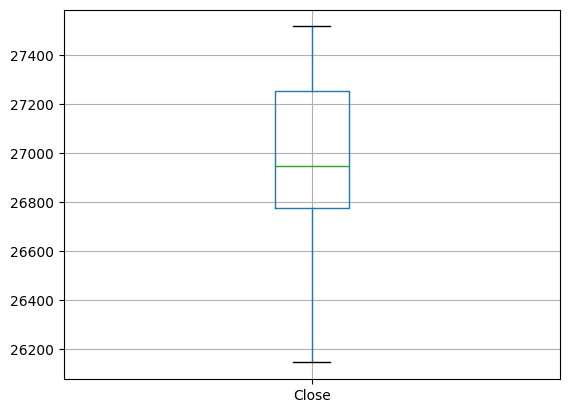

In [7]:
limpieza_datos()
df_bitcoin_limpio.boxplot(['Close'])

#Tomar Decisiones

In [8]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio
  if precio_actual>=media_bitcoin and tendencia =='Baja':
    algoritmo_decision='Vender'
  elif precio_actual < media_bitcoin and tendencia == 'Alta':
        algoritmo_decision = 'Comprar'
  else:
        algoritmo_decision = 'Esperar'
    
  return algoritmo_decision

In [9]:
tomar_decisiones()
print('Precio Promedio del Bitcoin: ',media_bitcoin)
print('Precio Actual del Bitcoin: ',precio_actual)
print('Tendencia: ',tendencia)
print('Desicion del Algoritmo: ',algoritmo_decision)

Precio Promedio del Bitcoin:  26963.220514644905
Precio Actual del Bitcoin:  26649.83
Tendencia:  Baja
Desicion del Algoritmo:  Esperar


#Visualización

In [10]:

def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision,df_bitcoin_limpio
  df_bitcoin['Promedio'] = media_bitcoin
  plt.figure(figsize=(16,5))
  plt.title('Bitcoin')
  df_bitcoin['Close'].plot(label='Precio Actual')
  df_bitcoin['Promedio'].plot(label='Promedio')
  plt.xlabel('Fecha')
  plt.ylabel('Precio')
  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]),xytext=(-130, 80), textcoords='offset points',
  arrowprops=dict(arrowstyle='->'),fontsize=14)
  plt.show()
     

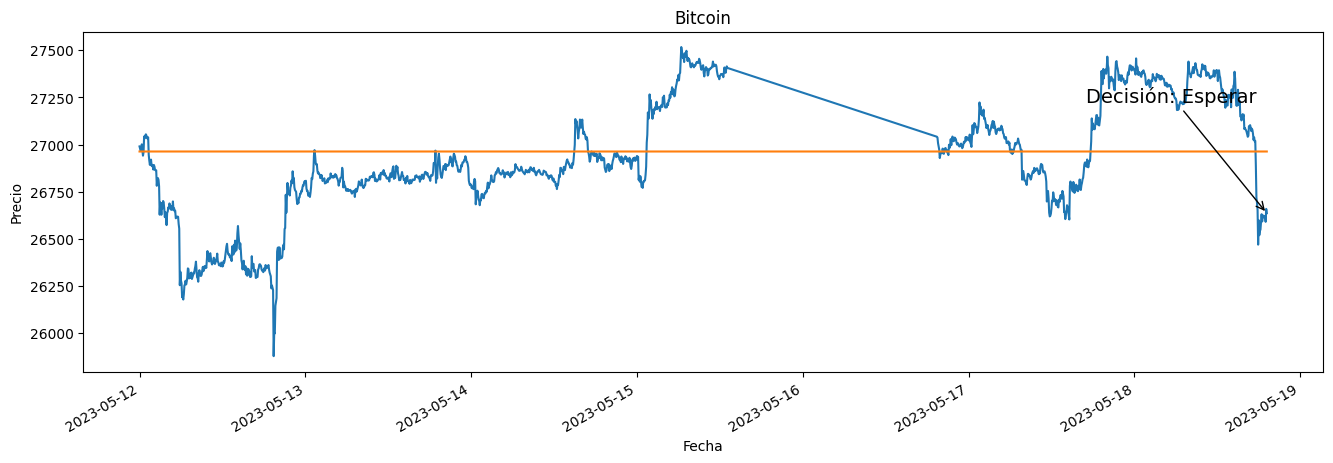

In [11]:
visualizacion()

#Automatizar

[*********************100%***********************]  1 of 1 completed


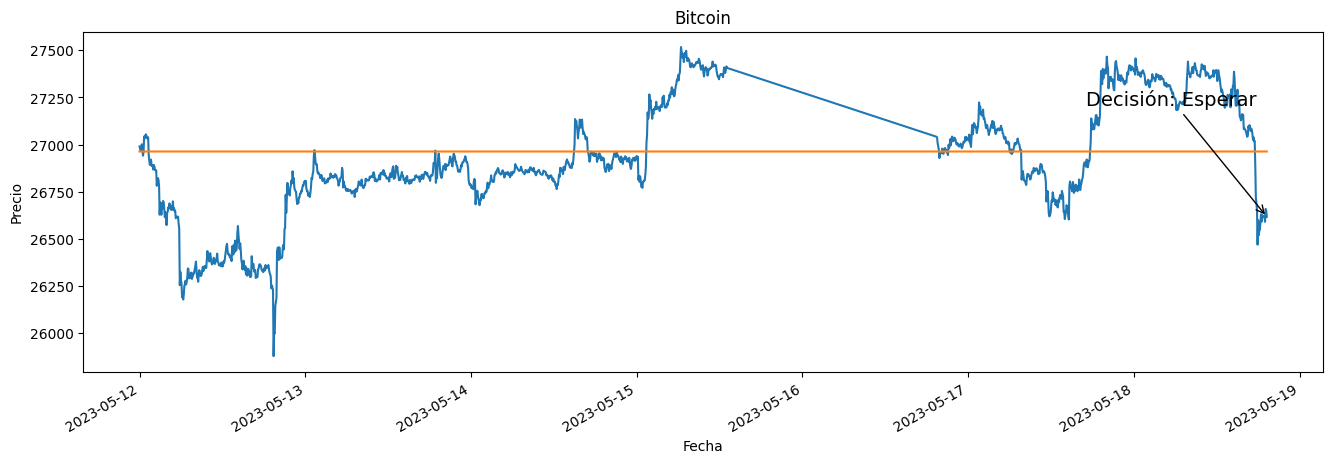

In [ ]:
from IPython.display import clear_output
import time

while True:
    clear_output()
    importar_base_datos_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)